# Assignment 1 : Softmax_Regression + L2 Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
y = y.astype(np.uint8)

In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [7]:
enc.fit(y[:,np.newaxis])

<ipython-input-7-78fc683d5810>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  enc.fit(y[:,np.newaxis])


OneHotEncoder()

In [8]:
Y = enc.transform(y[:,np.newaxis]).toarray()

<ipython-input-8-fd377ab0d802>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.transform(y[:,np.newaxis]).toarray()


In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [10]:
X_train = X_train / 255
X_test = X_test / 255

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [13]:
def compute_cost(X, T, W, lambda_=0):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    
    reg_l2 = (lambda_ / 2) *  np.sum(np.dot(W.T, W))
    
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + reg_l2
    
    return cost

In [14]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [15]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size, val_ratio, lambda_):
    N = len(T)
    cost_history = np.zeros((iterations+1,1))
    shuffled_indices = np.random.permutation(N)
    X_total    = X[shuffled_indices]
    T_total    = T[shuffled_indices]
    
    val_N      = int(N * (1 - val_ratio))
    X_shuffled = X_total[:val_N]
    T_shuffled = T_total[:val_N]
    X_eval     = X_total[val_N:]
    T_eval     = T_total[val_N:]

    for i in range(iterations+1):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
            
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch))
        cost_history[i] = compute_cost(X_batch, T_batch, W, lambda_)
        if i % 10000 == 0:
            print("ep :", i, cost_history[i][0], compute_cost(X_eval, T_eval, W, lambda_))

    return (cost_history, W)

In [16]:
lambdas = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 0.8, 1]

for l in lambdas : #{
    X = np.hstack((np.ones((np.size(X_train, 0),1)), X_train))
    T = y_train

    K = np.size(T, 1)
    M = np.size(X, 1)
    W = np.zeros((M,K))

    iterations    = 50000
    learning_rate = 0.01
    val_ratio     = 0.2
    lambda_       = 0

    initial_cost  = compute_cost(X, T, W)

    print(f'\n>> lambda : {l}')
    print("Initial Cost is: {}".format(initial_cost[0][0]))

    (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, val_ratio, lambda_)
#}


>> lambda : 0
Initial Cost is: 2.3024850979937352
ep : 0 2.2831541555964074 [[2.2935462]]
ep : 10000 0.3193758351230489 [[0.38314251]]
ep : 20000 0.3575824718176719 [[0.35801532]]
ep : 30000 0.331933413987564 [[0.33425947]]
ep : 40000 0.43453196420447265 [[0.33130651]]
ep : 50000 0.03405101227285814 [[0.40226227]]

>> lambda : 1e-06
Initial Cost is: 2.3024850979937352
ep : 0 2.2689032927926367 [[2.29016807]]
ep : 10000 0.48002060432771393 [[0.39130109]]
ep : 20000 0.3408860551964585 [[0.35833873]]
ep : 30000 0.3011565242168361 [[0.33846411]]
ep : 40000 0.14283067178179418 [[0.32934317]]
ep : 50000 0.02369706515417677 [[0.39285171]]

>> lambda : 1e-05
Initial Cost is: 2.3024850979937352
ep : 0 2.2753685048996126 [[2.29179788]]
ep : 10000 0.45200945151559296 [[0.38407996]]
ep : 20000 0.29292952964980584 [[0.34846656]]
ep : 30000 0.19490314480012128 [[0.34161702]]
ep : 40000 0.24197861895133543 [[0.31897538]]
ep : 50000 0.021252263021251144 [[0.38161054]]

>> lambda : 0.0001
Initial Cost

In [17]:
X = np.hstack((np.ones((np.size(X_train, 0),1)), X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations    = 50000
learning_rate = 0.01
val_ratio     = 0.2
lambda_       = 1e-5

initial_cost  = compute_cost(X, T, W)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, val_ratio, lambda_)

Initial Cost is: 2.3024850979937352 

ep : 0 2.281465865892039 [[2.29266369]]
ep : 10000 0.4538471050916931 [[0.38912396]]
ep : 20000 0.38718738984344475 [[0.35560686]]
ep : 30000 0.18521518382267624 [[0.34746713]]
ep : 40000 0.2702371635775948 [[0.32745246]]
ep : 50000 0.027895793183109686 [[0.37088113]]


In [18]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.8958


# Assignment 2 : Plot Decision Boundary

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

In [20]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

training score : 0.995 (multinomial)
Decision Line Equation 0 : y = 43.57048441305908 * x + (4.095153678178035)
Decision Line Equation 1 : y = 3.810217320400762 * x + (-0.5005472299246592)
Decision Line Equation 2 : y = 1.9363945308144788 * x + (-4.595700908102694)

training score : 0.976 (ovr)
Decision Line Equation 0 : y = -3.475758417272506 * x + (2.258169938884576)
Decision Line Equation 1 : y = 3.780485092958259 * x + (-0.4380765843590444)
Decision Line Equation 2 : y = 1.0457758465246452 * x + (-2.6962465232436204)



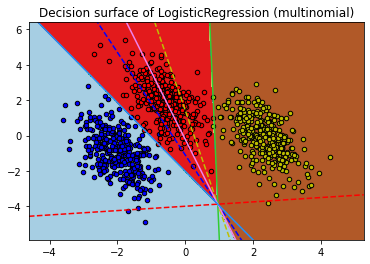

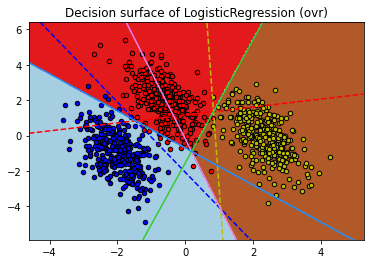

In [21]:
for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)
        
    
    # =======================================================
    # Added
    def plot_decision_line(c, color) : #{      
        
        coef_ = np.concatenate((coef[:c], coef[c+1:]), axis=0)
        intercept_ = np.concatenate((intercept[:c], intercept[c+1:]), axis=0)

        def decision_line(x0) : #{
            return ((-(x0 * (coef_[0, 0] - coef_[1, 0])) - (intercept_[0] - intercept_[1])) / (coef_[0,1] - coef_[1, 1]))
        #}
        
        def decision_line_eq() : #{
            x_coef = (coef_[0, 0] - coef_[1, 0])
            y_coef = (coef_[0, 1] - coef_[1, 1])
            intcpt = (intercept_[0] - intercept_[1])
            return f"y = {x_coef / y_coef} * x + ({intcpt})"
        #}
        
        print(f"Decision Line Equation {c} : {decision_line_eq()}")
        
        plt.plot([xmin, xmax], [decision_line(xmin), decision_line(xmax)],
                 ls="-", color=color)        
    #}
    
    line_color = ["limegreen", "violet", "dodgerblue"]
    for i, color in zip(clf.classes_, line_color) : #{
        plot_decision_line(i, color)
    #}
    
    print()
    # =======================================================

plt.show()

# How to get Decision Boundaries

Logistic Regression으로 얻은 coefficient와 intercept를 이용하여 계산한 eq1과 eq2를 아래와 같이 표현할 수 있다. (위 그림에서 점선) 
$$eq1 : a_1x +b_1y + c_1 = 0$$
$$eq2 : a_2x +b_2y + c_2 = 0$$

<br>

점(x', y')과 직선(ax + by + c = 0) 사이의 거리는 아래와 같이 표현할 수 있다.
$$|ax' + by' + c| \over \sqrt{x'^2 + y'^2}$$

<br>

결정 경계(Decision Boundary)는 eq1과 eq2으로부터 거리가 같은 점들의 집합이다.
$${|a_1x' + b_1y' + c_1| \over \sqrt{x'^2 + y'^2}} = {|a_2x' + b_2y' + c| \over \sqrt{x'^2 + y'^2}}$$

<br>

따라서, 결정 경계는 위 식을 풀면 구할 수 있다. 즉, 아래의 식이 결정 경계가 된다.  
절댓값이 씌워져 있으므로 총 2개의 값이 존재할 수 있지만, 하나의 예시만 표현했다. 두 식 중 하나만 결정 경계가 된다.

$$y = - {{a_1 - a_2} \over {b_1 - b_2}}x + {{c_1 - c_2} \over {b_1 - b_2}}$$